In [1]:
import time
import torch
import sbibm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import argparse

In [2]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def get_thetas_grid(min_theta, max_theta):
    theta1 = np.linspace(min_theta, max_theta, 200)
    theta2 = np.linspace(min_theta, max_theta, 200)
    thetas_unflat = np.meshgrid(theta1, theta2)
    return np.vstack((thetas_unflat[0].flatten(), thetas_unflat[1].flatten())).T.astype(np.float32)

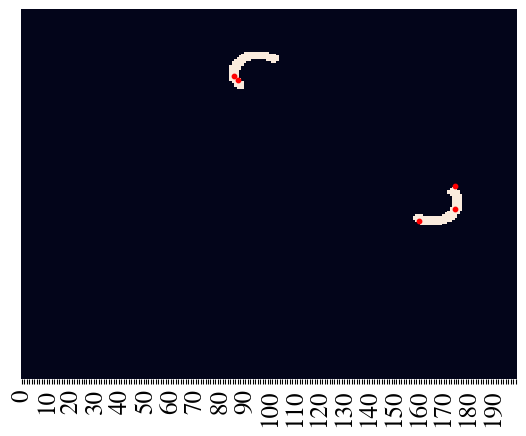

In [146]:
task_name = "two_moons"

task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()

sims = 10_000 # same number for both test and calibration
calibration_theta = prior.sample((sims,))
calibration_x = simulator(calibration_theta)
calibration_theta = calibration_theta[...,:2]

thetas = get_thetas_grid(-1, 1)
test_sim = 1
test_theta = prior.sample((test_sim,))
test_x = simulator(test_theta)
test_theta = test_theta[...,:2]
test_x_tiled = np.tile(test_x, (thetas.shape[0], 1)).astype(np.float32)

device = "cpu"
cached_fn = f"{task_name}.nf"
with open(cached_fn, "rb") as f:
    encoder = pickle.load(f)
encoder.to(device)

cal_scores = 1 / encoder.log_prob(calibration_theta.to(device), calibration_x.to(device)).detach().cpu().exp().numpy()
desired_coverages = [0.75, 0.85, 0.95]
desired_coverage = desired_coverages[-1]
    
probs = encoder.log_prob(thetas, test_x_tiled).detach().cpu().exp().numpy()
probs_map = probs.reshape((200, 200))

conformal_quantile = np.quantile(cal_scores, q = desired_coverage)
plot_ = sns.heatmap((1 / probs_map) < conformal_quantile, cbar=False, xticklabels=True, yticklabels=False)

for ind, label in enumerate(plot_.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

N = 5
theta_hat = encoder.sample(N, test_x)[0].detach().cpu().numpy()
plt.scatter((theta_hat[:,0] + 1) * 100, (theta_hat[:,1] + 1) * 100, s=10, color='red')

In [160]:
theta_pos = theta_hat.copy()
theta_vel = np.zeros(theta_pos.shape)

In [167]:
positions = []

T = 500 # time steps of repulsive simulation
for _ in range(T):
    positions.append(theta_pos.copy())
    
    # compute distance vectors for repulsion forces
    tiled_theta_pos = np.tile(theta_pos, (theta_pos.shape[0], 1, 1))
    tiled_theta_pos = np.transpose(tiled_theta_pos, (1, 0, 2))
    dist_vectors = theta_pos - tiled_theta_pos

    flat_dist_vectors = dist_vectors.reshape(N * N, -1)
    flat_dists = np.linalg.norm(flat_dist_vectors, axis=-1)
    flat_dists = np.tile(flat_dists, (2, 1)).T

    # compute repulsive forces
    K = 1.0 # arbitrary constant for simulating repulsion
    flat_unit_vectors = flat_dist_vectors / np.linalg.norm(flat_dists)
    flat_forces = K * flat_unit_vectors * flat_dists ** -2
    forces = flat_forces.reshape(N, N, -1)

    # update velocities and positions
    time_step = 0.01
    total_force = np.nansum(forces, axis=0)
    theta_pos += theta_vel * time_step
    theta_vel += total_force * time_step

/tmp/ipykernel_2044413/3324827194.py:19: RuntimeWarning: divide by zero encountered in power
  flat_forces = K * flat_unit_vectors * flat_dists ** -2
/tmp/ipykernel_2044413/3324827194.py:19: RuntimeWarning: invalid value encountered in multiply
  flat_forces = K * flat_unit_vectors * flat_dists ** -2


In [168]:
for idx, position in enumerate(positions):
    plt.scatter((position[:,0] + 1) * 100, (position[:,1] + 1) * 100, s=10, color='red')
    plt.xlim(-1000, 1000)
    plt.ylim(-1000, 1000)
    plt.savefig(f"images/frame_{idx}.png")
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [169]:
import os
import imageio

images = []
for idx in range(len(positions)):
    images.append(imageio.imread(f"images/frame_{idx}.png"))
imageio.mimsave('repulsion.gif', images)

/tmp/ipykernel_2044413/4118266928.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"images/frame_{idx}.png"))
